In [1]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
# MCMC parameters
num_walkers = 50
num_threads = mp.cpu_count() # or a different number if you prefer

my_driver = orbitize.driver.Driver('B2-B3-orbitizetab.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  5.5, # total system mass [M_sun]
                                  2.41, # total parallax of system [mas]
                                  mass_err=0.5, # mass error [M_sun]
                                  plx_err=0.03, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})

In [14]:
# RUN MCMC
total_orbits = 2e4*num_walkers # number of steps x number of walkers (at lowest temperature)
burn_steps = 2e5 # steps to burn in per walker
thin = 5 # only save every 2nd step

my_driver.sampler.run_sampler(int(total_orbits), burn_steps=int(burn_steps), thin=int(thin))

Burn in complete

Run complete


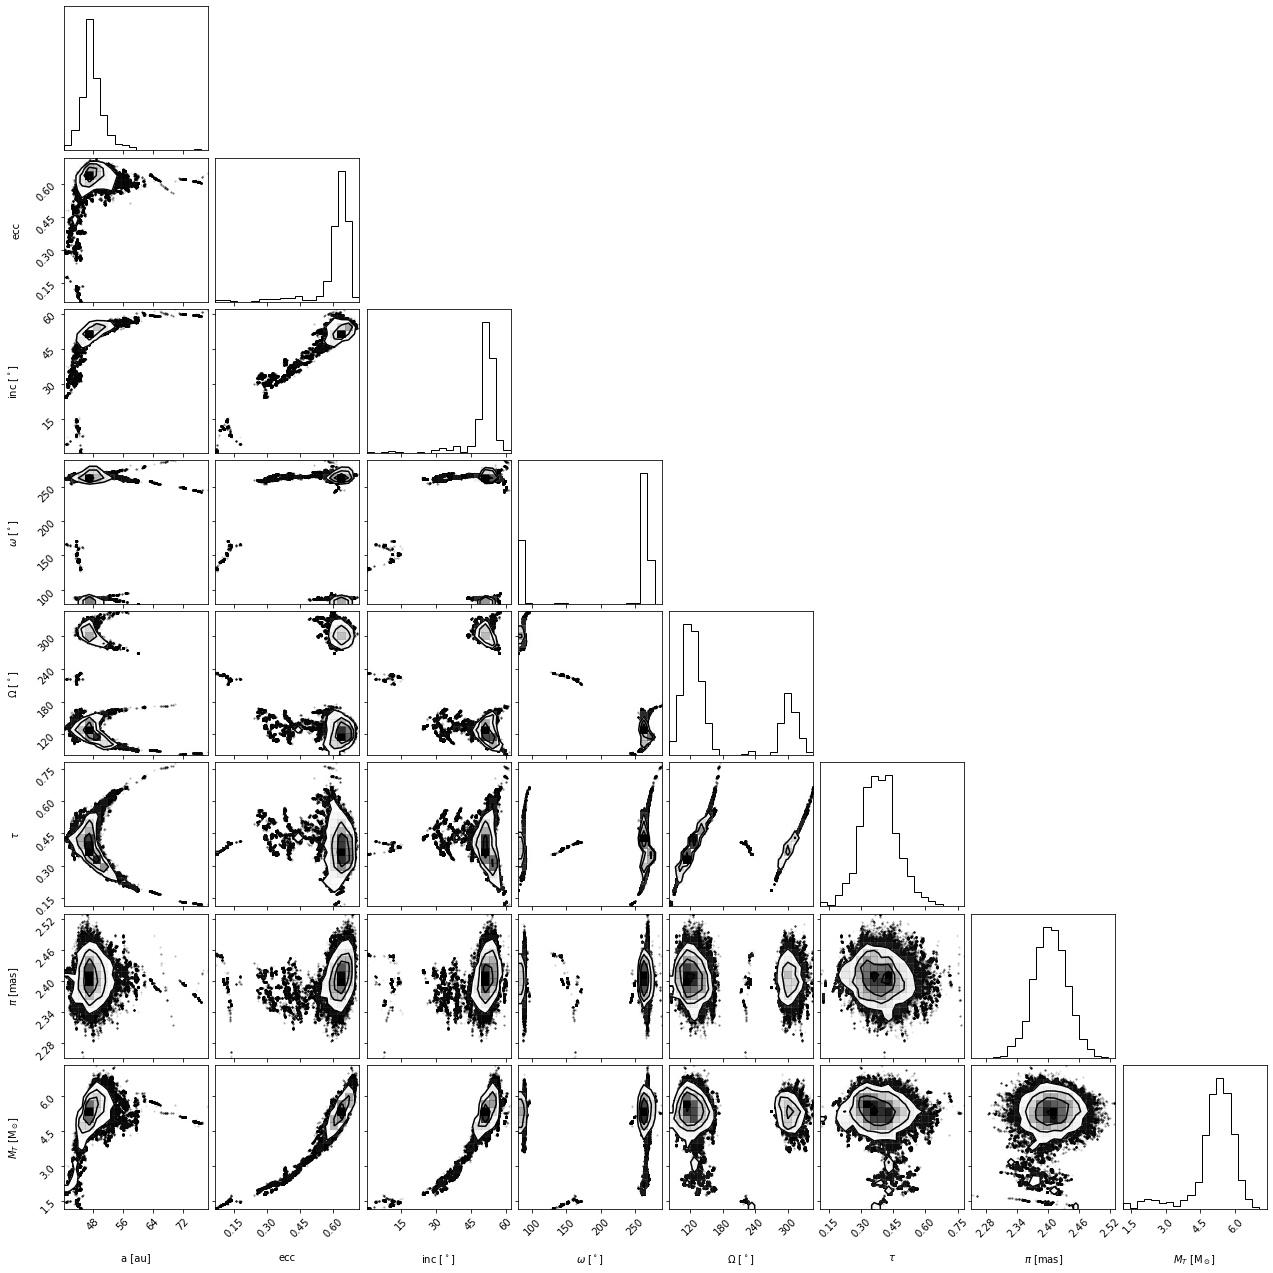

In [4]:
#MCMC PLOTS
corner_plot_fig = my_driver.sampler.results.plot_corner() # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png') # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

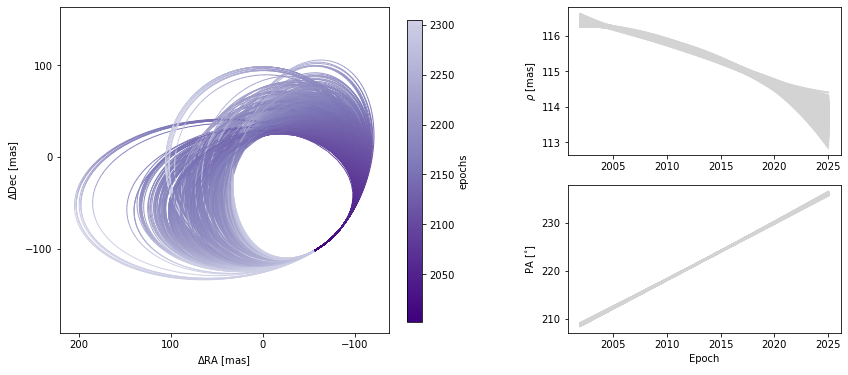

In [7]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 1500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig('b2b3_orbit_plot.png') # This is matplotlib.figure.Figure.savefig()

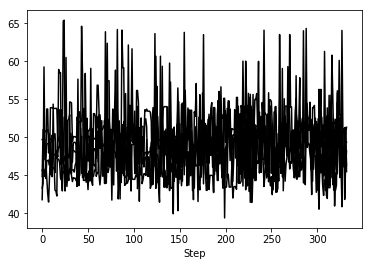

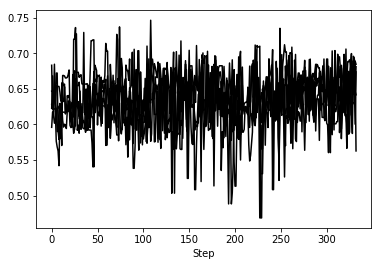

In [8]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(param_list=['sma1','ecc1'], n_walkers=5)

In [13]:
# save result as hdf5
hdf5_filename='my_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

In [ ]:
# # save orbits result as csv
# import pandas as pd
# data = myResults.post
# df = pd.DataFrame(data, columns=myResults.labels)
# df.to_csv('test.csv')

In [3]:
# load in saved hdf5 result
hdf5_filename='my_posterior_lab.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

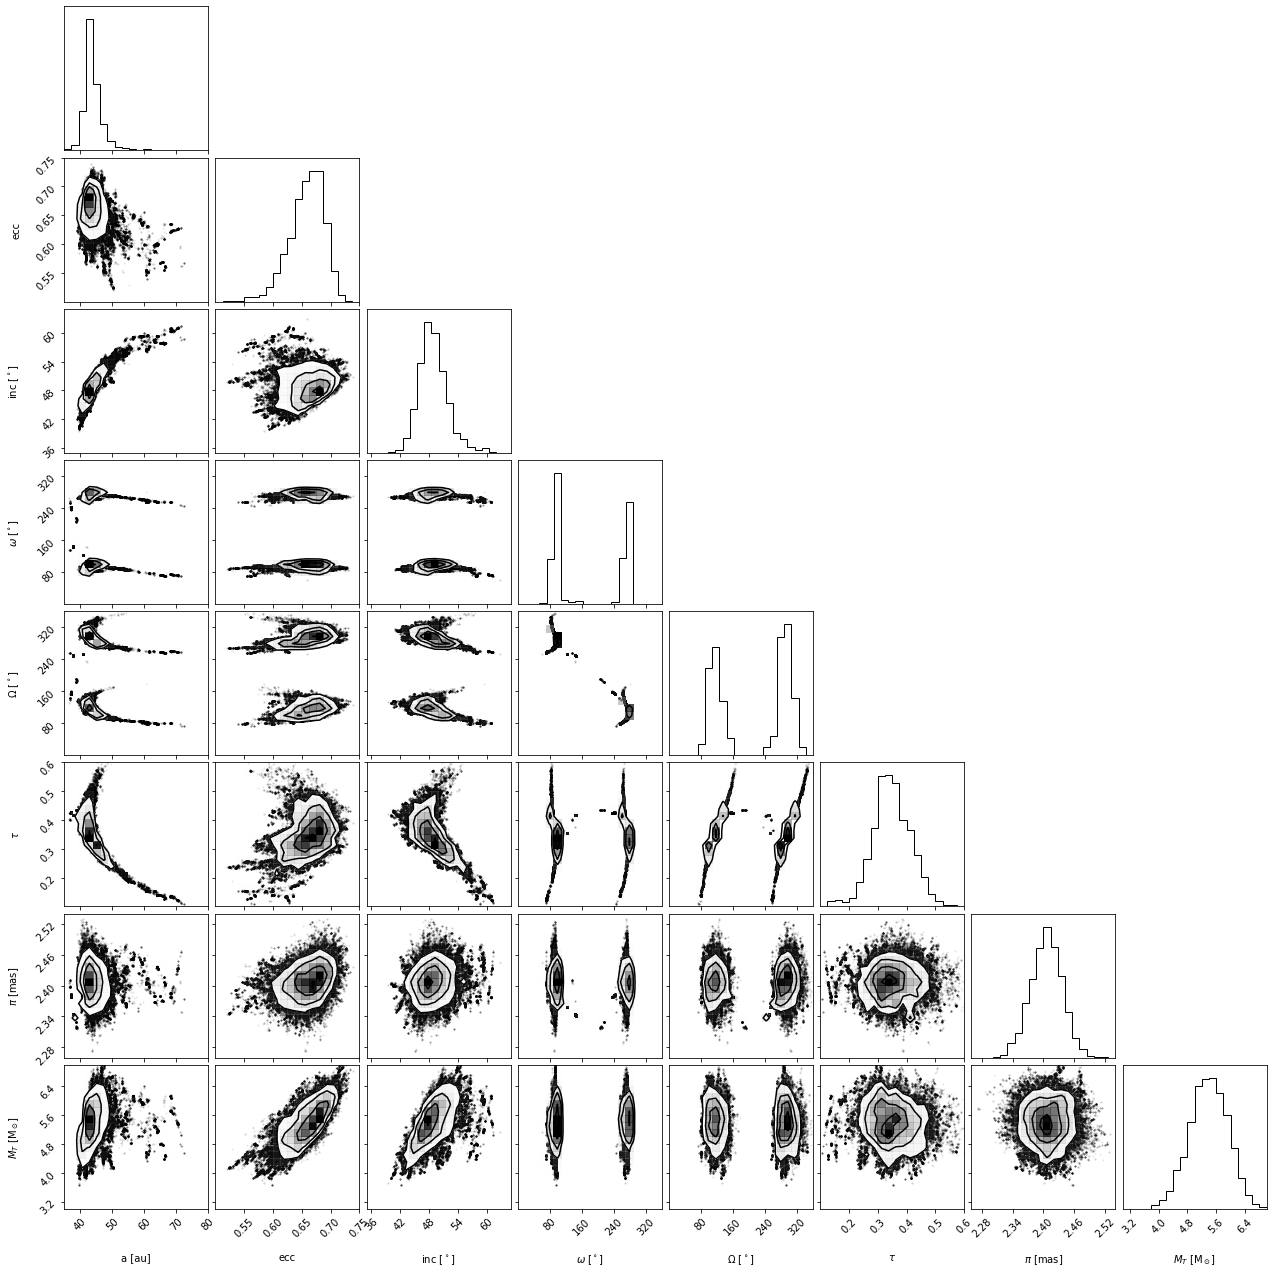

In [16]:
#MCMC PLOTS
range_values = [(35,80),(0.5,0.75),(35,65),(0, 360),(0,360),(0.1,0.6),(2.26,2.54),(3.0,7.0)]
corner_plot_fig = loaded_results.plot_corner(
    range=range_values,
) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('b2b3_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

<Figure size 1008x432 with 0 Axes>

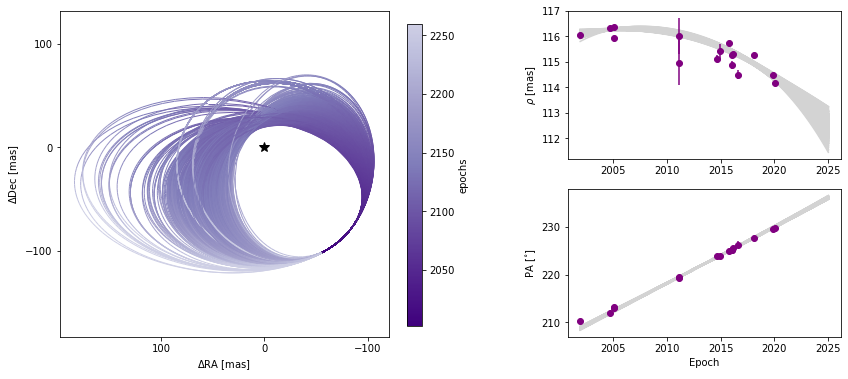

In [17]:
epochs = my_driver.system.data_table['epoch']

orb_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 1500, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)

ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

from astropy.time import Time

# grab data from Driver object
data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
sep = data_tab['quant1']; sep_err = data_tab['quant1_err']
pa = data_tab['quant2']; pa_err = data_tab['quant2_err']

# add data to sep panel
ax_sep.errorbar(
    epochs_yr, sep, sep_err,
    color='purple', linestyle='', fmt='o', zorder=3
)

# add data to PA panel
ax_pa.errorbar(
    epochs_yr, pa, pa_err,
    color='purple', linestyle='', fmt='o', zorder=3
)
ax_orb.plot(0,0,marker="*",color='black',markersize=10)

# zoom in a bit
# ax_sep.set_xlim(2011.25,2013)
# ax_pa.set_xlim(2011.25,2013)
# ax_sep.set_ylim(2450,2550)
# ax_pa.set_ylim(323,330)

orb_fig.savefig('b2b3_orbit_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

In [31]:
# positions for magao data

# semimajor axis 1, eccentricity 1, inclination 1,
# argument of periastron 1, position angle of nodes 1,
# epoch of periastron passage 1
data = loaded_results.post
JD = 58793# 2019-11-06 58793
sma = data[:, 0]
ecc = data[:, 1]
inc = data[:, 2]
aop = data[:, 3]
pan = data[:, 4]
tau = data[:, 5]
plx = 5.5
mtot = 2.41
ra, dec, vz = orbitize.kepler.calc_orbit(JD, sma, ecc, inc, aop, pan, tau, plx, mtot)

In [40]:
import numpy as np
from scipy import stats
me = np.mean(ra)
med = np.median(ra)
print(me, med)

-200.18394128904833 -200.0869128165316


In [22]:
results = pd.read_csv(
    'visao_b2-b3.csv',
    header = 0,
    sep = ',',
    usecols = lambda x:x in ["Date", "med sep", "med PA", "stdev sep", "stdev PA"],
    nrows = 9
)

for pa_i in range(len(results['med PA'])):
    pa = results['med PA'][pa_i]
    if pa < 90:
        results['med PA'][pa_i] += 180

In [23]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['Date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['med sep']
outtable['sep_err'] = results['stdev sep']
outtable['pa'] = results['med PA']
outtable['pa_err'] = results['stdev PA']
outtable.to_csv('visao-b2b3-orbitizelike.csv', index=False)
outtable

,epoch,object,sep,sep_err,pa,pa_err
0,56388.0,1.0,14.724274,0.107122,222.701469,0.388696
1,56389.0,1.0,14.549567,0.098303,222.511326,0.177892
2,56990.0,1.0,14.889658,0.142302,225.286725,0.055219
3,57367.0,1.0,15.017311,0.153823,226.489034,2.518220
4,57709.0,1.0,14.617388,0.036466,226.681237,0.015062
5,57788.0,1.0,14.484011,0.052299,226.690009,0.165388
6,57790.0,1.0,14.457903,0.038578,226.877635,0.047179
7,57798.0,1.0,14.491549,0.061778,226.815344,0.318754
8,58234.0,1.0,14.541079,0.126381,228.321249,0.056525


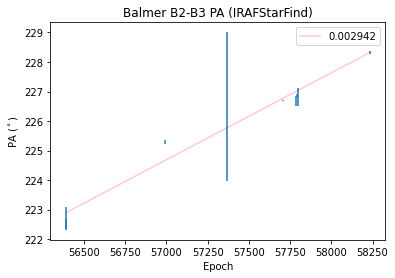

In [33]:
# my result
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
#plt.xlim(-500, 6700)
plt.title('Balmer B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa.png', dpq=200)

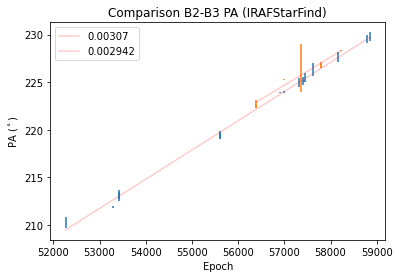

In [32]:
# compare to NIRC2
nircast = pd.read_csv('B2-B3-orbitizetab.csv')

slope, intercept, r_value, p_value, std_err = stats.linregress(nircast['epoch'], nircast['pa'])
plt.errorbar(nircast['epoch'], nircast['pa'], yerr=nircast['pa_err'], ls='none')
plt.plot(nircast['epoch'], intercept + slope*nircast['epoch'], 'r', alpha=0.2, label=round(slope,6))

slope, intercept, r_value, p_value, std_err = stats.linregress(outtable['epoch'], outtable['pa'])
plt.errorbar(outtable['epoch'], outtable['pa'], yerr=outtable['pa_err'], ls='none')
plt.plot(outtable['epoch'], intercept + slope*outtable['epoch'], 'r', alpha=0.2, label=round(slope,6))

plt.legend()
#plt.xlim(-500, 6700)
plt.title('Comparison B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
plt.savefig('visao_pa_compare.png', dpq=200)